# Chicken consumption and Covid-19 incidence by country
The goal of this notebook is to analyse a possible relation between poultry (chicken) production/consumption and the incidence of Covid-19 in world countries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

The dataframe has been generated [here](preprocessing.ipynb) and we load it:

In [2]:
df = pd.read_csv(os.path.join('data', 'poultry.csv'))
df.head()

,Code,Year,production,country,sum_of_cases,sum_of_deaths,confirmed_cases_in_the_last_14_days,population,yearly_change,netchange,density,landarea,migrants,fert_rate,med_age,urban_pop_perc,worldshare,consumption
0,AFG,2018,28850,Afghanistan,37599.0,1375.0,770.0,38928346,2.33,886592,60,652860,-62920,4.6,18,25,0.50,NaN
1,ALB,2018,15587,Albania,7654.0,232.0,1904.0,2877797,-0.11,-3120,105,27400,-14000,1.6,36,63,0.04,NaN
2,DZA,2018,294663,Algeria,39444.0,1391.0,6940.0,43851044,1.85,797990,18,2381740,-10000,3.1,29,73,0.56,6.281003
3,AGO,2018,27208,Angola,1966.0,90.0,802.0,32866272,3.27,1040977,26,1246700,6413,5.6,17,67,0.42,NaN
4,ATG,2018,96,Antigua and Barbuda,93.0,3.0,1.0,97929,0.84,811,223,440,0,2.0,34,26,0.00,NaN


Normalize relevant features by population:

In [3]:
df = df.rename(columns={'sum_of_deaths': 'confirmed_deaths', 'sum_of_cases': 'confirmed_cases'})
df['confirmed_deaths'] = df['confirmed_deaths'] / df['population'] * 1000000
df['confirmed_cases'] = df['confirmed_cases'] / df['population'] * 1000000
df['production'] = df['production'] / df['population'] * 1000

## Chicken prodution X confirmed cases
The number of confirmed cases is an indicator, though not ideal, since it depends also on the intensity of the test policy in each country.

[]

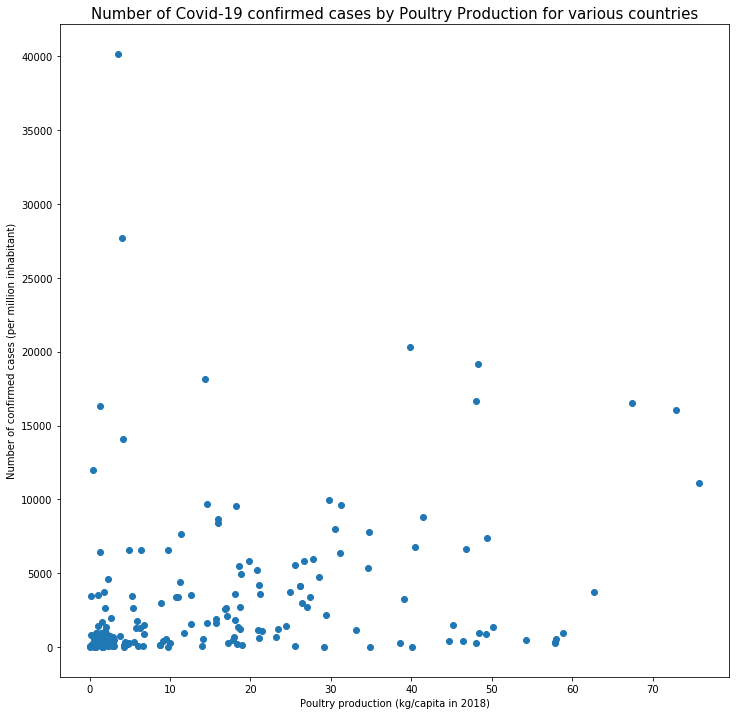

In [4]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df['production'].values, df['confirmed_cases'].values)
ax.set_xlabel('Poultry production (kg/capita in 2018)')
ax.set_ylabel('Number of confirmed cases (per million inhabitant)')
ax.set_title('Number of Covid-19 confirmed cases by Poultry Production for various countries', fontsize=15)

plt.plot()

On the bottom left we see a cluster of countries with low chicken production and low number of confirmed cases. There are however some outliers with 
1. high production but low number of confirmed cases (along the x-axis on the bottom)
2. low production but high number of cases (along the y-axis on the right)


Let's have a look at the 1st kind of outliers:

In [5]:
outliers1 = df[(df['confirmed_cases'] <= 1000) & (df['production'] >= 10)]['country'].values.tolist()
outliers1

['Australia',
 'Barbados',
 'Brunei',
 'China',
 'Egypt',
 'Fiji',
 'Greece',
 'Guyana',
 'Hungary',
 'Jamaica',
 'Japan',
 'Jordan',
 'Latvia',
 'Lithuania',
 'Malaysia',
 'Mauritius',
 'Myanmar',
 'New Zealand',
 'Nicaragua',
 'Slovakia',
 'South Korea',
 'Taiwan',
 'Thailand',
 'Trinidad and Tobago',
 'Tunisia']

Many of them are countries that took early drastical measures against Covid-19 (China, Taiwan, South Korea) or that implemented very early lockdown (Greece, Slovakia, New Zealand...)

Now let's have a look on the second kind of outliers:

In [6]:
outliers2 = df[(df['confirmed_cases'] >= 2500) & (df['production'] <= 2.5)]['country'].values.tolist()
outliers2

['Bermuda',
 'Equatorial Guinea',
 'Gabon',
 'Guam',
 'Iraq',
 'Kyrgyzstan',
 'Luxembourg',
 'Oman']

Luxembourg is a small countries with many workers from neighbouring countries commuting there for work.

Let's remove those outliers:

In [7]:
outliers = outliers1 + outliers2

In [8]:
df_no_outliers = df.loc[~df['country'].isin(outliers)]

[]

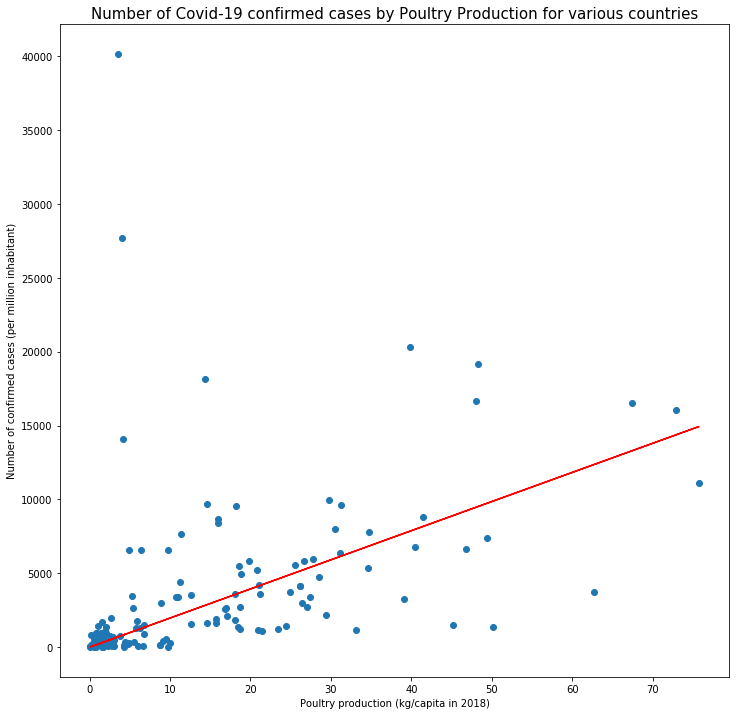

In [9]:
linear_regressor = LinearRegression(fit_intercept=False, normalize=True)
X = df_no_outliers['production'].values.reshape(-1, 1)
y = df_no_outliers['confirmed_cases'].values.reshape(-1, 1)
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)


fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df_no_outliers['production'].values, df_no_outliers['confirmed_cases'].values)
ax.plot(df_no_outliers['production'].values, y_pred, c='red')
ax.set_xlabel('Poultry production (kg/capita in 2018)')
ax.set_ylabel('Number of confirmed cases (per million inhabitant)')
ax.set_title('Number of Covid-19 confirmed cases by Poultry Production for various countries', fontsize=15)

plt.plot()

Statistical analysis of this linear regression:

In [10]:
mod = sm.OLS(X, y)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.404
Method:                 Least Squares   F-statistic:                              97.26
Date:                Mon, 24 Aug 2020   Prob (F-statistic):                    9.01e-18
Time:                        00:17:22   Log-Likelihood:                         -600.59
No. Observations:                 142   AIC:                                      1203.
Df Residuals:                     141   BIC:                                      1206.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0021      0.000      9.862      0.000       0.002       0.002
==============================================================================
Omnibus:                       53.369   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.078
Skew:                          -0.963   Prob(JB):                    1.42e-112
Kurtosis:                      12.130   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The [F-statistic](https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-analysis-of-variance-anova-and-the-f-test) is good, the [R-squared](https://corporatefinanceinstitute.com/resources/knowledge/other/r-squared/) pretty low.

## Chicken prodution X confirmed deaths
The number of confirmed deaths is also biased, it depends on what is considered as a Covid-19 related death is the various countries (some include all deaths of patients having Covid-19, others only deaths with Covid-19 is established as the cause), but still it's a better indicator than the number of confirmed cases.

[]

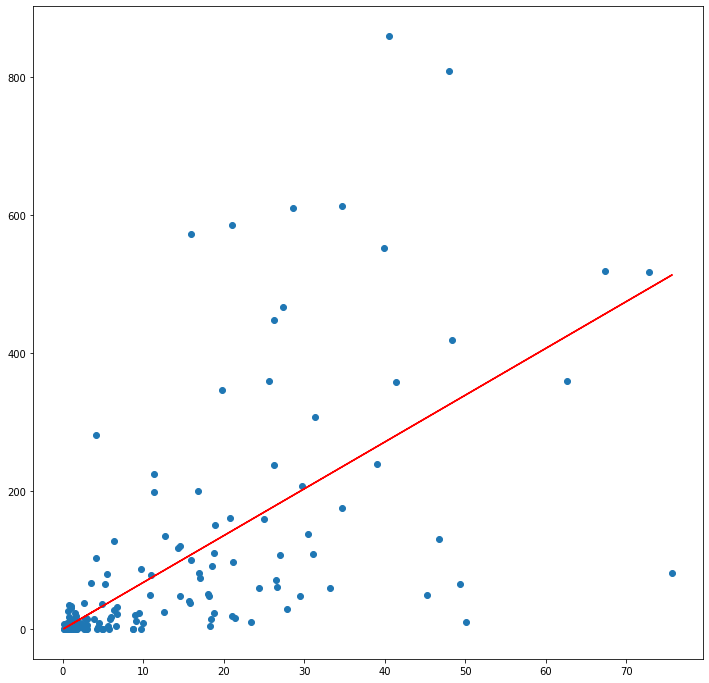

In [11]:
linear_regressor = LinearRegression(fit_intercept=False, normalize=True)
X = df_no_outliers['production'].values.reshape(-1, 1)
y = df_no_outliers['confirmed_deaths'].values.reshape(-1, 1)
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df_no_outliers['production'].values, df_no_outliers['confirmed_deaths'].values)
ax.plot(df_no_outliers['production'].values, y_pred, c='red')

plt.plot()

Statistical analysis of this linear regression:

In [12]:
mod = sm.OLS(X, y)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.545
Model:                            OLS   Adj. R-squared (uncentered):              0.541
Method:                 Least Squares   F-statistic:                              168.6
Date:                Mon, 24 Aug 2020   Prob (F-statistic):                    7.56e-26
Time:                        00:17:22   Log-Likelihood:                         -582.01
No. Observations:                 142   AIC:                                      1166.
Df Residuals:                     141   BIC:                                      1169.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0803      0.006     12.983      0.000       0.068       0.093
==============================================================================
Omnibus:                       42.831   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.727
Skew:                           1.093   Prob(JB):                     2.76e-31
Kurtosis:                       7.360   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time, with a better indicator, bot the F-statistics and the R-squared are much better, indicating a stronger relationship between poultry production and the target variable.

## Chicken consumption X confirmed deaths
For the chicken consumption, we have data only for 41 countries.

In [13]:
df_consumption = df[df['consumption'].notna()]

[]

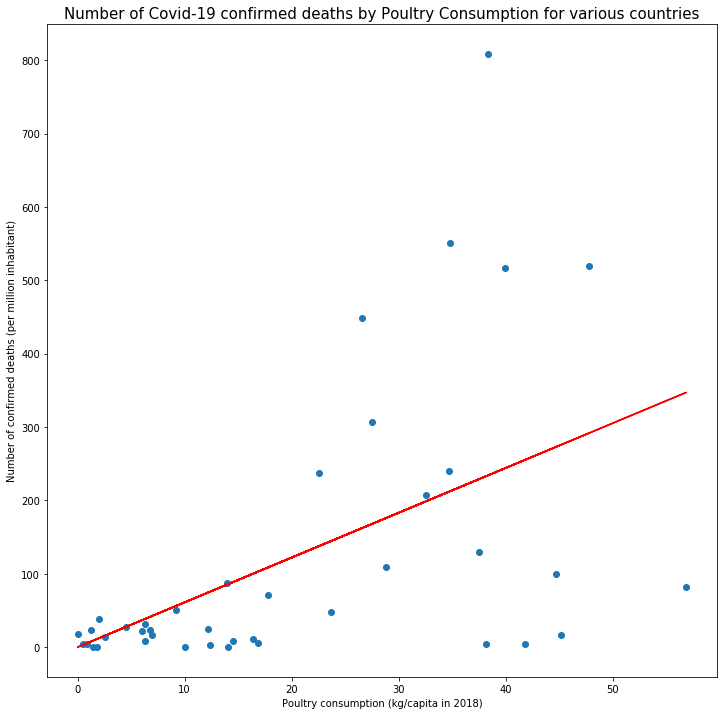

In [14]:
linear_regressor = LinearRegression(fit_intercept=False, normalize=True)
X = df_consumption['consumption'].values.reshape(-1, 1)
y = df_consumption['confirmed_deaths'].values.reshape(-1, 1)
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df_consumption['consumption'].values, df_consumption['confirmed_deaths'].values)
ax.plot(df_consumption['consumption'].values, y_pred, c='red')
ax.set_xlabel('Poultry consumption (kg/capita in 2018)')
ax.set_ylabel('Number of confirmed deaths (per million inhabitant)')
ax.set_title('Number of Covid-19 confirmed deaths by Poultry Consumption for various countries', fontsize=15)

plt.plot()

Note:
* There is a cluster (on the bottom left) of countries with very low chicken consumption and very low number of confirmed cases.
* below 25kg/year chicken consumption, almost all countries are below th regression line

In [15]:
mod = sm.OLS(X, y)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.486
Model:                            OLS   Adj. R-squared (uncentered):              0.473
Method:                 Least Squares   F-statistic:                              37.79
Date:                Mon, 24 Aug 2020   Prob (F-statistic):                    2.93e-07
Time:                        00:17:22   Log-Likelihood:                         -177.02
No. Observations:                  41   AIC:                                      356.0
Df Residuals:                      40   BIC:                                      357.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0795      0.013      6.147      0.000       0.053       0.106
==============================================================================
Omnibus:                        6.824   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                5.519
Skew:                           0.764   Prob(JB):                       0.0633
Kurtosis:                       3.945   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion
There are pros and contras in considering chicken production/consumption as having an influence on the incidence of Covid-19.

Pros:
* The statistical relation is stronger with a more accurate target variable (confirmed deaths vs. confirmed cases)
* The chicken production/consumption should be completely irrelevant, but looks statistically quite strong, despite of other factors having an obiously strong impact (sanitary measures like lockdown, health system quality etc.)

Contra:
* Correlation doesn't imply causality

In general, it looks like for low chicken production/consumption, the incidence of Covid-19 in the population is also low. When the chicken production/consumption increases, the incidence is more scattered, but still with an increasing trend. An explanation could be that while poultry has an impact, it can be counter-balanced by other strong factors (sanitary measures).